In [10]:
%load_ext autoreload
%autoreload 2

from tqdm import tqdm
from math import sqrt,erf
from multiprocessing import Pool
from itertools import product, repeat
from matplotlib import pyplot as plt
from matplotlib import animation
import matplotlib as mpl
import numpy as np
from varname import nameof
from itertools import product
from matplotlib.cm import get_cmap
import colorcet as cc
import subprocess
import os, shutil
from time import time
import functools
from scipy import special
import scipy
from IPython.display import display, clear_output
import source.fermionise as fermionise
import source.eigenstateRG as eigRG


plt.style.use('ggplot')
markers = ["o", "X", "P", "p", "*"]
cols = [p['color'] for p in plt.rcParams['axes.prop_cycle']]
plt.rc('text.latex', preamble=r'\usepackage{amsmath}\usepackage{braket}\usepackage{nicefrac}')
plt.rcParams.update({'font.size': 30,
                     'figure.figsize': (11,7),
                     'axes.facecolor': 'white',
                     'axes.edgecolor': 'lightgray',
                     "figure.autolayout": 'True',
                     'axes.xmargin': 0.03,
                     'axes.ymargin': 0.05,
                     'axes.grid': False,
                     'axes.linewidth': 5,
                     'lines.markersize': 15,
                     'text.usetex': True,
                     'lines.linewidth': 8,
                     "legend.frameon": True,
                     "legend.framealpha": 0.7,
                     "legend.handletextpad": 1,
                     "legend.edgecolor": "black",
                     "legend.handlelength": 1,
                     "legend.labelspacing": 0,
                     "legend.columnspacing": 1,
                     "legend.fontsize": 35,
                    })
linestyles = ["-", "--", ":"]
bbox = dict(boxstyle="round", facecolor="lightgray")

D0 = 1
deltaD = 0.001
plt.plot([], [])
plt.show()
clear_output()

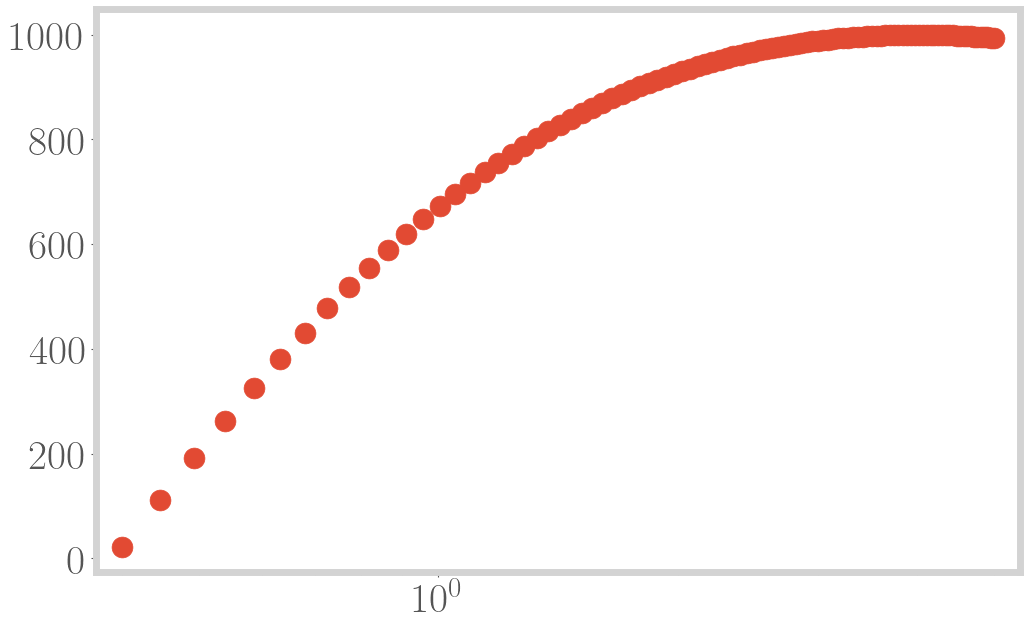

In [7]:
def get_RG_flow(J0_by_D0, Ub_by_J=0, plot=False):
    """ Returns the flow of couplings in the form of two ndarrays J and D.
    Each ndarray is in ascending order of the bandwidth. """
    J0 = D0 * J0_by_D0
    Ub = - Ub_by_J * J0
    omega = -D0/2
    
    ### initialise arrays with UV values
    D = [D0]
    J = [J0]
    
    ### apply URG transformations until bandwith vanishes
    ### or J reduces to zero.
    while D[-1] >= deltaD and J[-1] >= 0:
        
        ### URG equation
        deltaJ = - J[-1] * (J[-1] + 4 * Ub) / (omega - D[-1]/2 + J[-1]/4) * deltaD
        
        ### Check if denominator has changed sign, 
        ### then append renormalised values to array
        if (omega - (D[-1] - deltaD)/2 + (J[-1] + deltaJ)/4) * (omega - D0/2 + J0/4) > 0:
            D.append(D[-1] - deltaD)
            J.append(J[-1] + deltaJ)
        else:
            break
    
    ### plot values
    if plot:
        plt.plot(np.array(D)/D0, np.array(J)/J0, marker="o")
        plt.xlabel(r"$D/D_0$")
        plt.ylabel(r"$J/J_0$")
    return np.flip(D), np.flip(J)

for J0_by_D0 in np.linspace(0.4, 5, 100):
    D, J = get_RG_flow(J0_by_D0)
    plt.scatter(J0_by_D0, D[0] / deltaD, color=cols[0])
    # plt.scatter(J0_by_D0, J[0], color=cols[1])
plt.xscale("log")
plt.show()

In [15]:
def KondoMERG(J0_by_D0, num_entangled, both_sectors=False):
    D, J = get_RG_flow(J0_by_D0)
    omega = -D0/2
    time_list = []
    # for num_IOMs in range(2, 15, 2):
    for num_IOMs in [2]:
        t = time()
        Ek = np.linspace(D[0] - deltaD * num_entangled, D[0], num_entangled)
        if both_sectors:
            alpha_arr = np.repeat([Ji / (2 * (omega - Di/2 + Ji/4)) for Ji, Di in zip(J, D)], 2)[:num_IOMs]
            IOMconfigs = [1 if i % 2 == 0 else 0 for i in range(num_IOMs)]
            print (IOMconfigs)
        else:
            alpha_arr = [Ji / (2 * (omega - Di/2 + Ji/4)) for Ji, Di in zip(J, D)][:num_IOMs]
            IOMconfigs = [0] * num_IOMs
        # print (Ek)
        init_couplings = [Ek, J[0], 0]
        decomposition_arr = eigRG.getWavefunctionRG(init_couplings, alpha_arr, num_entangled, num_IOMs, 
                                                   IOMconfigs, "getKondoHamiltonian", "getEtaKondo"
                                                  )
        print (decomposition_arr[1])
        computation_results = eigRG.computations(decomposition_arr,
                                                {"VNE": [2, 3],
                                                }
                                               )
        # print (computation_results["I2"])
        # time_list.append(time() - t)
        # plt.plot(computation_results["VNE"], 'o')
        # plt.show()
        # plt.plot(computation_results["VNE"], 'o')
    print (time_list)

KondoMERG(0.5, 2, True)

[1, 0]


[autoreload of source.eigenstateRG failed: Traceback (most recent call last):
  File "/home/kirito/storage/miniconda3/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/home/kirito/storage/miniconda3/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 475, in superreload
    module = reload(module)
             ^^^^^^^^^^^^^^
  File "/home/kirito/storage/miniconda3/lib/python3.11/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 621, in _exec
  File "<frozen importlib._bootstrap_external>", line 940, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/home/storage/research-projects/Tensor-Network-MERG/source/eigenstateRG.py", line 37, in <module>
    import fermionise
ModuleNotFoundError: No module named 'fermionise'
]


NameError: name 'getKondoHamiltonian' is not defined

In [ ]:
states = [[1,0], [1,1], [0,1]]
coeffs = [0.1, 0.2, 0.3]


In [ ]:
def func(args):
    x, n = args
    return x**(3**3**2)

num = 1000
power = 10
t = time()
results1 = [func((x, power)) for x in range(1, num)]
print (time() - t)
t = time()
results2 = Pool().map(func, [(x, power) for x in range(1, num)], chunksize=50)
# print (workers[0].get())
# print (workers[1])
# results = [worker.get() for worker in workers]
print (time() - t)

In [ ]:
def func(x):
    return np.arange(3)**x**4

p = Pool()
result = p.apply_async(func, (2,)).get()
print(result)

In [ ]:
import os
os.cpu_count()

In [ ]:
d1 = dict([("a", 1), ("b", 2)])
d2 = dict([("a", 0), ("b", 0), ("c", 0)])
d2.update(d1)
d2